In [28]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
import scipy
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Hyper parameters
num_classes = 10 # とりあえず10人で
num_epochs = 30
batch_size = 128
learning_rate = 0.01

input_size = 496 # 500秒を5秒ウィンドウで
sequence_length = 1250 # 1セグメントあたりのサンプル数 250Hz * 5s
hidden_size = 100 # 論文でいうhidden layerはこれ?
num_layers = 2 # Two-layered lstm?

In [ ]:
def down_sample(data):
    scipy.decimate()

In [ ]:
class MyDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None) -> None:
        super().__init__()
        self.wave = pd.read_csv(csv_file).to_numpy()
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = transform
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        wave = self.wave



    def __len__(self):
        return len(self.person_labels)

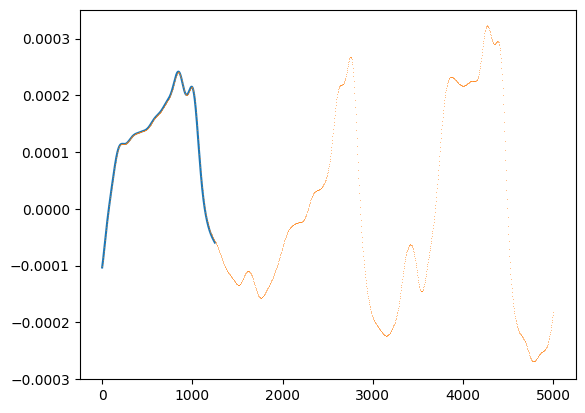

In [61]:
radar_frame = pd.read_csv('data/30-subjects-data/csv/radar_01.csv')

x = np.arange(0, 1215199)
wave = radar_frame.to_numpy()
wave = wave.flatten()
x_down = np.linspace(0, 1215199, 1215199//4)
wave_down = signal.decimate(wave, 4)
# # print(x.shape, wave.shape)
# # print(x, wave)
plt.plot(x[:1250], wave[:1250], label='data')
plt.plot(x_down[:1250], wave_down[:1250], ',', alpha=0.5)
plt.show()